Collaborative Filtering Recommendation System for movie recommendation is achieved by the following steps:
•Importing and merging data
•Performing EDA
•Preparing for cosine similarity
•Recommending movies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

1.Importing data:

In [2]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [3]:
movies.shape

(10329, 3)

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.shape

(105339, 4)

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [7]:
ratings.sort_values('movieId')

,userId,movieId,rating,timestamp
19960,158,1,4.5,1241296244
76418,536,1,3.0,860417689
76243,534,1,4.0,916850069
76000,532,1,3.0,1440345516
75826,531,1,5.0,1447661542
...,...,...,...,...
70603,475,148238,3.0,1451213043
66814,458,148626,4.0,1452014749
86152,576,148626,4.5,1451687664
105338,668,148626,4.5,1451148148


In [8]:
data = movies.merge(ratings, on="movieId")
data = data.drop("genres", axis=1)
data

,movieId,title,userId,rating,timestamp
0,1,Toy Story (1995),2,5.0,859046895
1,1,Toy Story (1995),5,4.0,1303501039
2,1,Toy Story (1995),8,5.0,858610933
3,1,Toy Story (1995),11,4.0,850815810
4,1,Toy Story (1995),14,4.0,851766286
...,...,...,...,...,...
105334,148238,A Very Murray Christmas (2015),475,3.0,1451213043
105335,148626,The Big Short (2015),458,4.0,1452014749
105336,148626,The Big Short (2015),576,4.5,1451687664
105337,148626,The Big Short (2015),668,4.5,1451148148


2.Performing EDA

In [9]:
data.drop(["title"], axis=1).corr()

,movieId,userId,rating,timestamp
movieId,1.000000,0.089403,-0.025446,0.518283
userId,0.089403,1.000000,-0.044781,0.039862
rating,-0.025446,-0.044781,1.000000,0.002697
timestamp,0.518283,0.039862,0.002697,1.000000


In [10]:
data.describe()

,movieId,userId,rating,timestamp
count,105339.000000,105339.000000,105339.000000,1.053390e+05
mean,13381.312477,364.924539,3.516850,1.130424e+09
std,26170.456869,197.486905,1.044872,1.802660e+08
min,1.000000,1.000000,0.500000,8.285650e+08
25%,1073.000000,192.000000,3.000000,9.711008e+08
50%,2497.000000,383.000000,3.500000,1.115154e+09
75%,5991.000000,557.000000,4.000000,1.275496e+09
max,149532.000000,668.000000,5.000000,1.452405e+09


In [11]:
data.isna().sum()

movieId      0
title        0
userId       0
rating       0
timestamp    0
dtype: int64

<Axes: xlabel='rating', ylabel='Density'>

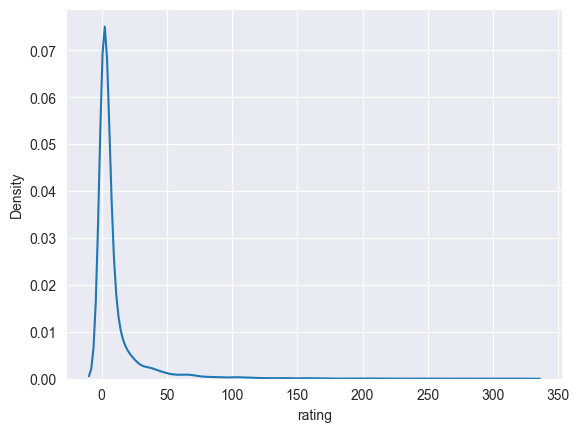

In [12]:
import seaborn as sns
ratings_vs_movies = data.groupby(["movieId"]).count()["rating"]
sns.kdeplot(ratings_vs_movies)

rating          Axes(0.125,0.11;0.352273x0.77)
timestamp    Axes(0.547727,0.11;0.352273x0.77)
dtype: object

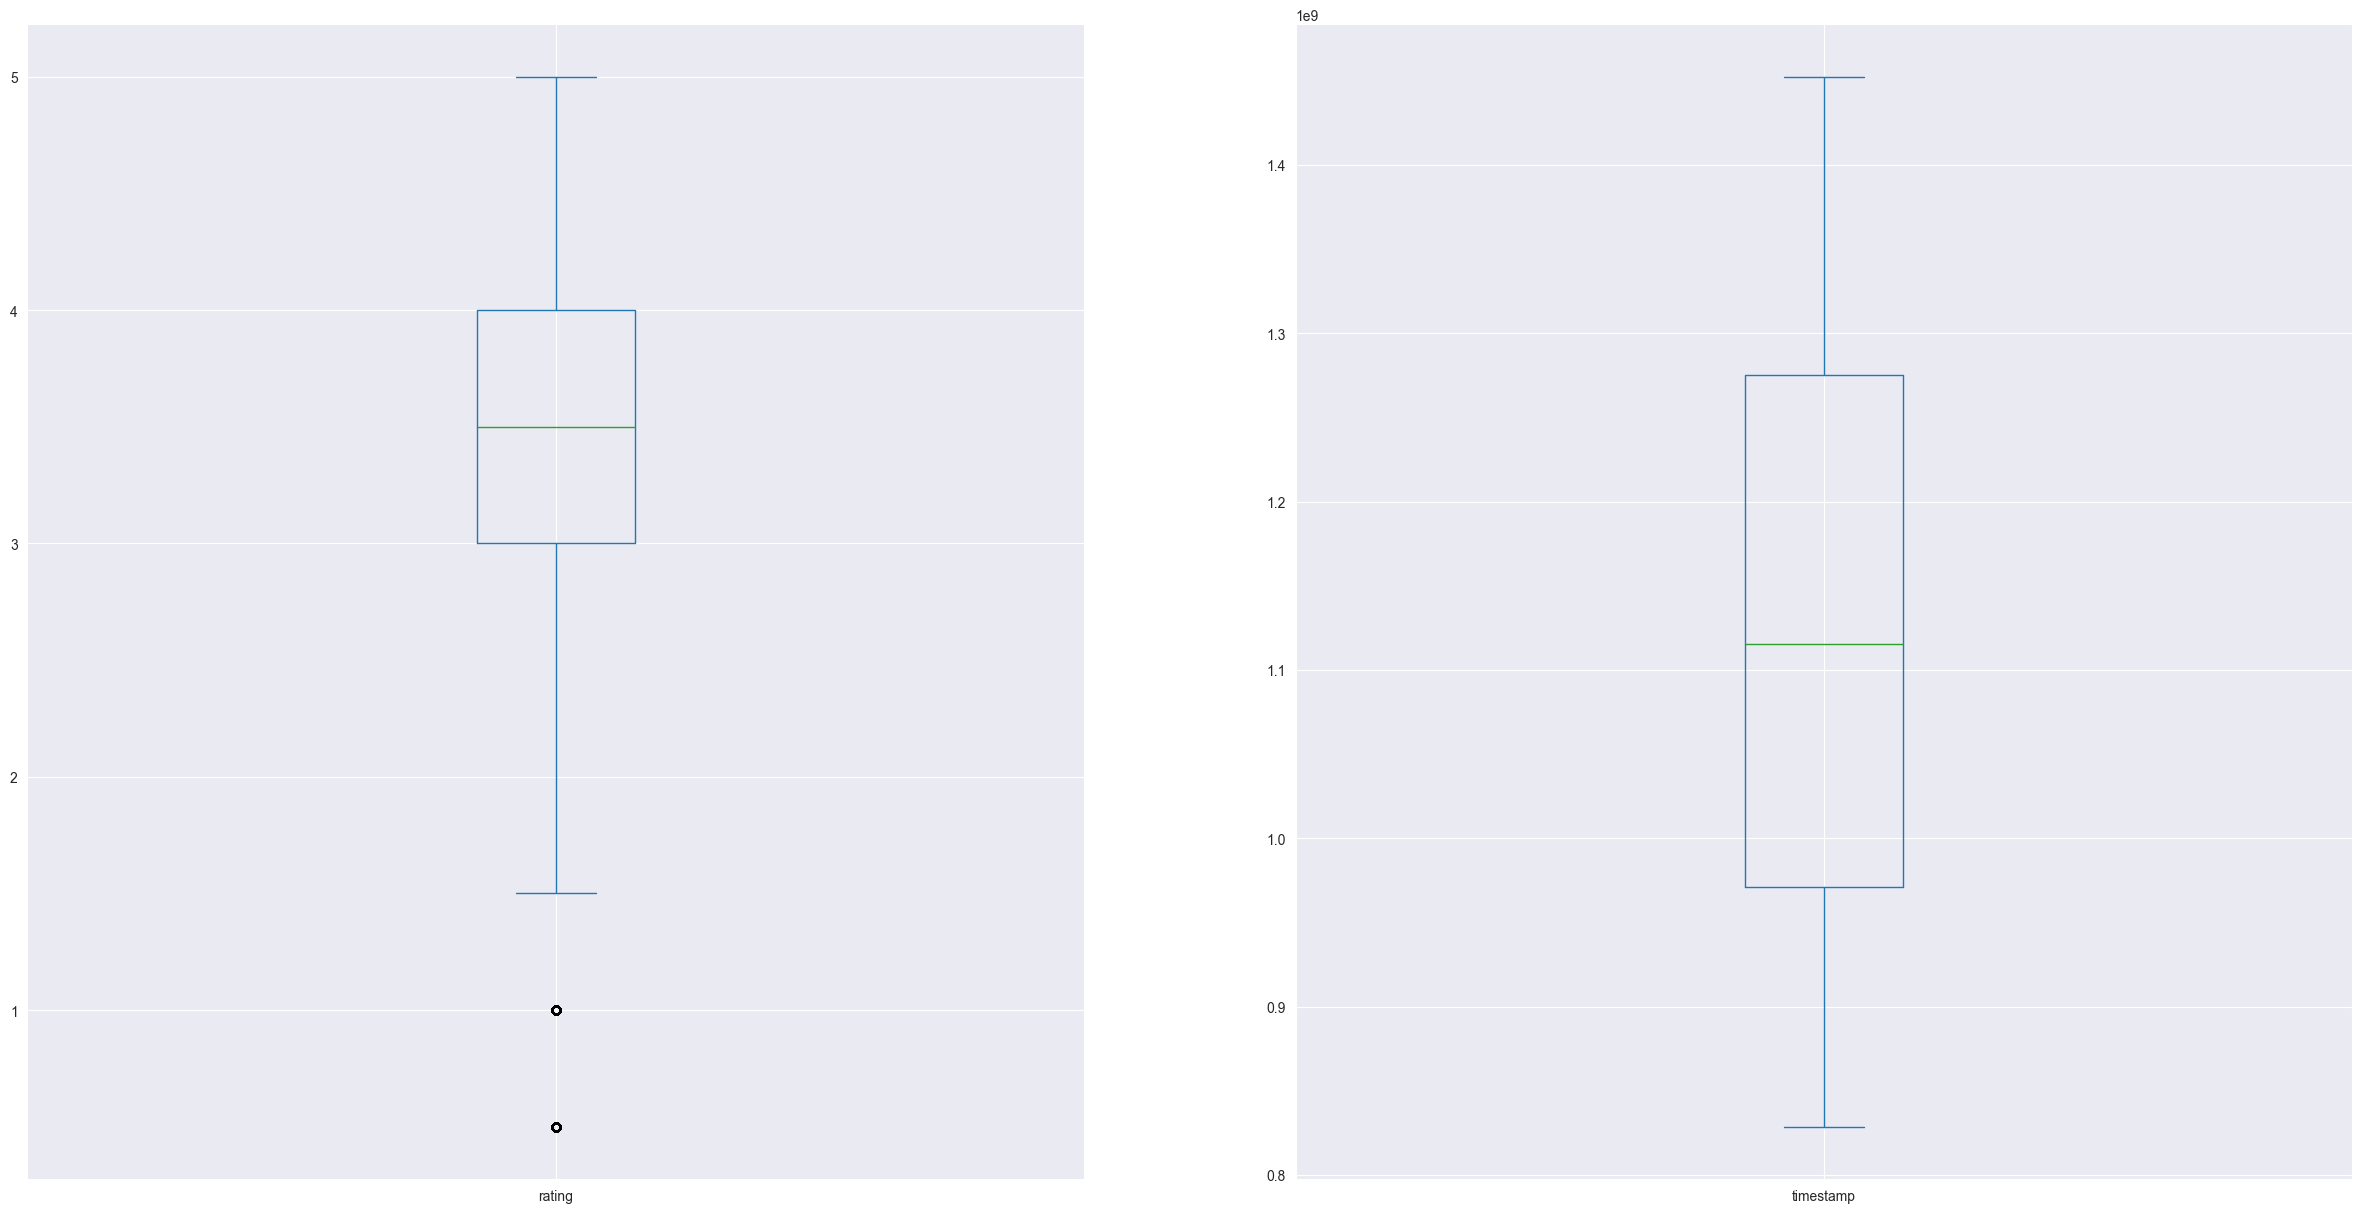

In [13]:
data.drop(["movieId", "userId", "title"], axis=1).plot(kind="box", subplots=True, layout=(1, 2), sharex=False, sharey=False, figsize=(30, 15))

In [14]:
def outlier_removal(data_frame, copy=False):
    #Tukey Fences
    for col in data_frame.columns:
        if col not in ["movieId", "title", "userId"]:
            Q1 = data_frame[col].quantile(0.25)
            Q3 = data_frame[col].quantile(0.75)

            k = 1.5
            up_lt, low_lt = (Q1 + k*(Q3- Q1)), (Q1 - k*(Q3 - Q1))

            data_frame[col] = np.where(data_frame[col] > up_lt, up_lt,
                                       np.where(data_frame[col] < low_lt, low_lt, data_frame[col]))

            print(col + " done")

    return data_frame

In [15]:
outlier_removal(data)

rating done
timestamp done


,movieId,title,userId,rating,timestamp
0,1,Toy Story (1995),2,4.5,8.590469e+08
1,1,Toy Story (1995),5,4.0,1.303501e+09
2,1,Toy Story (1995),8,4.5,8.586109e+08
3,1,Toy Story (1995),11,4.0,8.508158e+08
4,1,Toy Story (1995),14,4.0,8.517663e+08
...,...,...,...,...,...
105334,148238,A Very Murray Christmas (2015),475,3.0,1.427694e+09
105335,148626,The Big Short (2015),458,4.0,1.427694e+09
105336,148626,The Big Short (2015),576,4.5,1.427694e+09
105337,148626,The Big Short (2015),668,4.5,1.427694e+09


rating          Axes(0.125,0.11;0.352273x0.77)
timestamp    Axes(0.547727,0.11;0.352273x0.77)
dtype: object

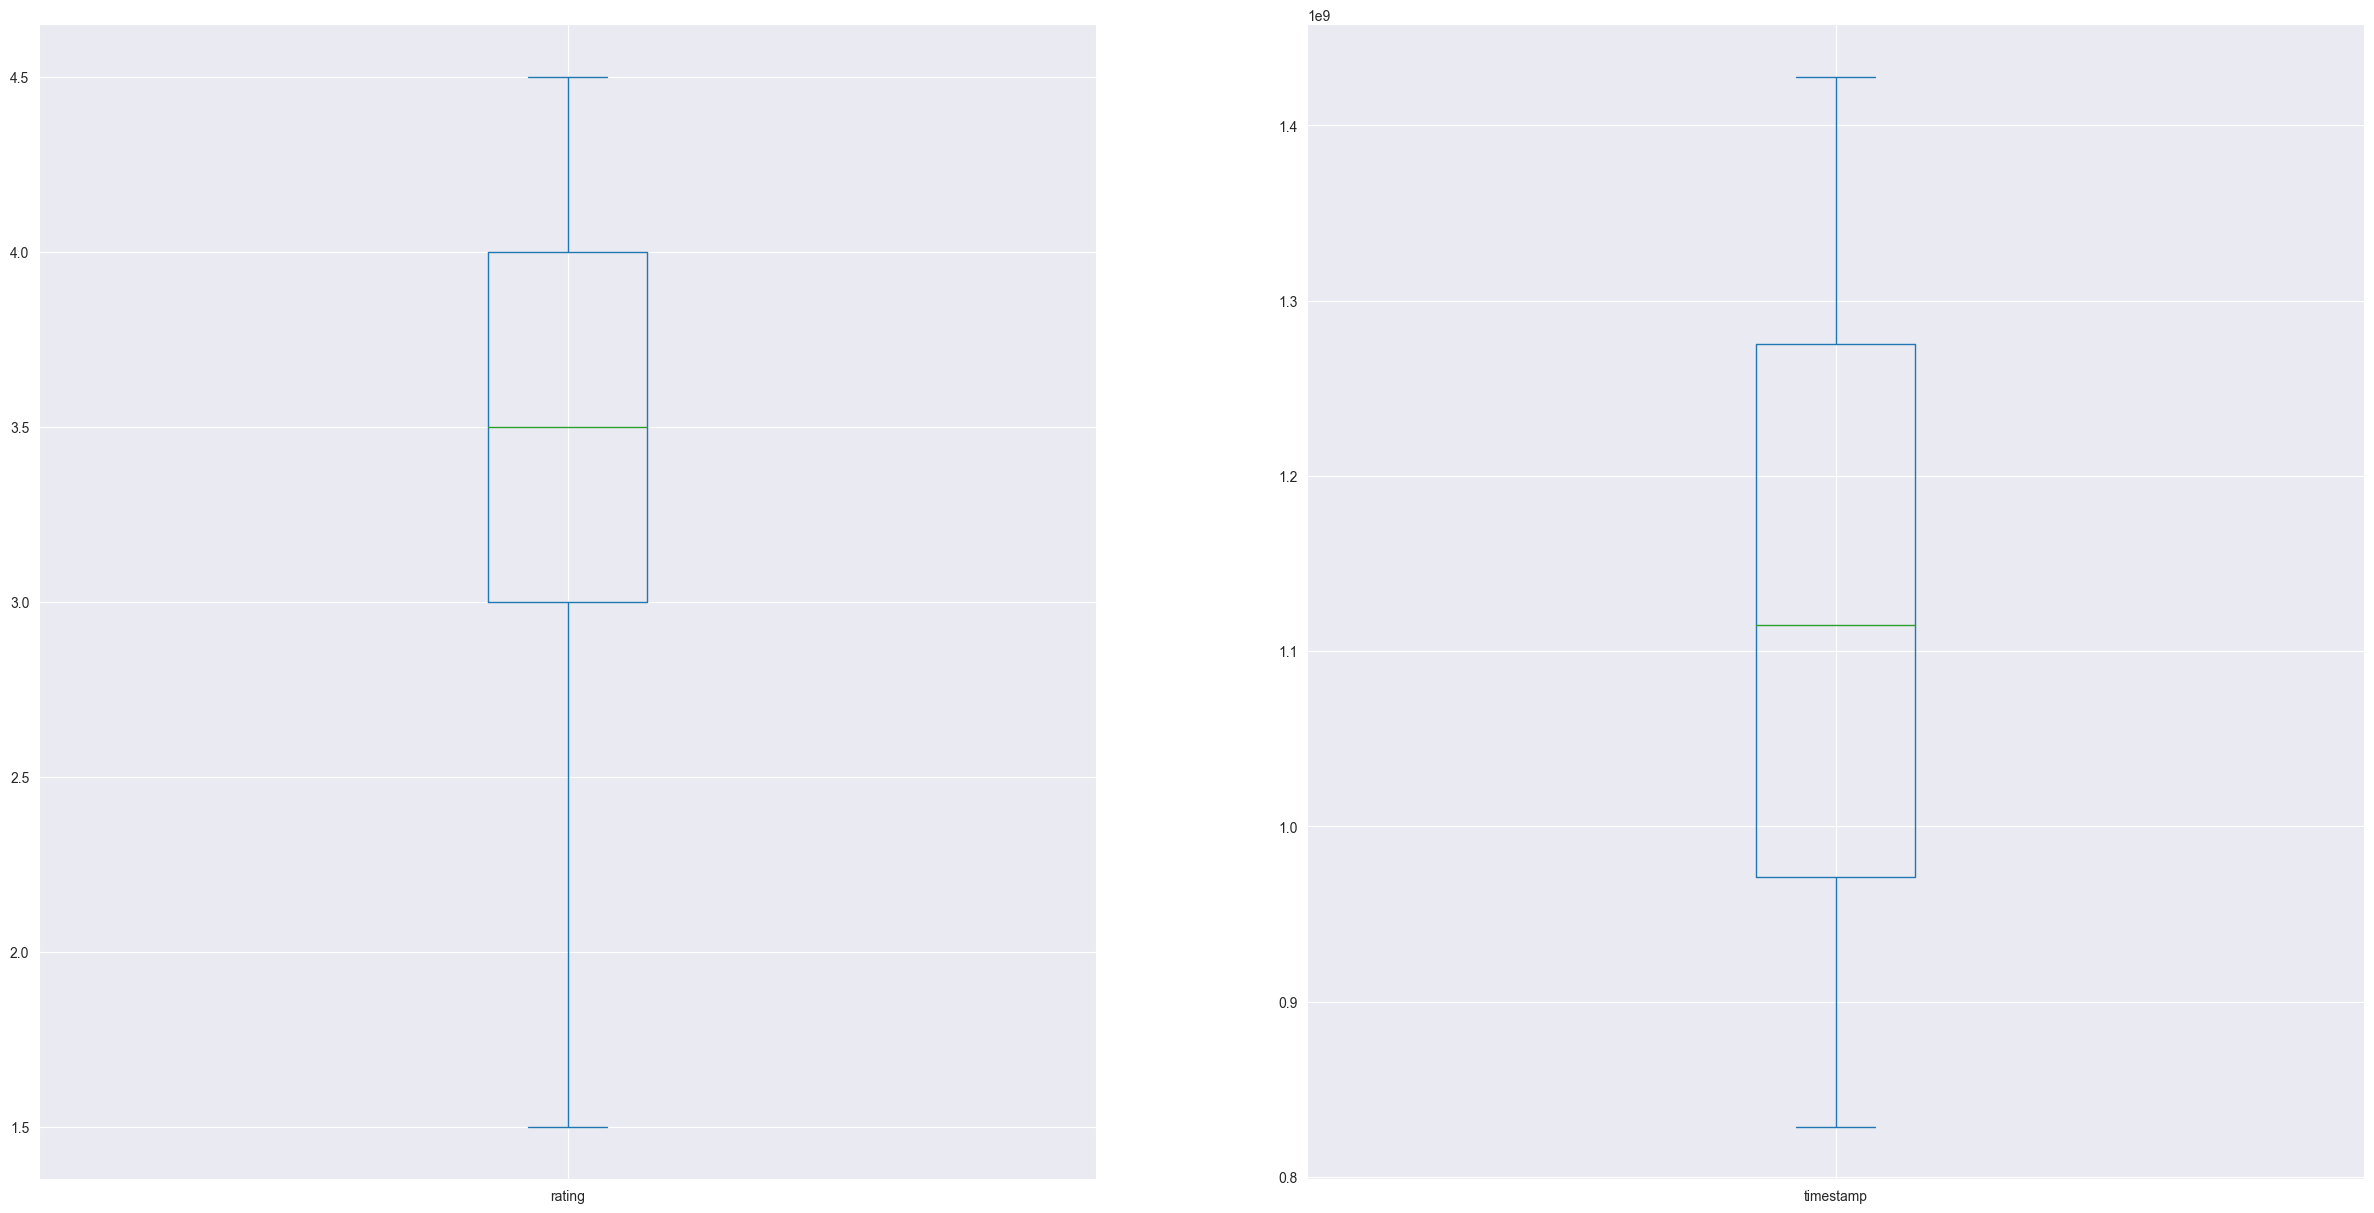

In [16]:
data.drop(["movieId", "userId", "title"], axis=1).plot(kind="box", subplots=True, layout=(1, 2), sharex=False, sharey=False, figsize=(30, 15))

C:\Users\kaush\anaconda3\envs\tf\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


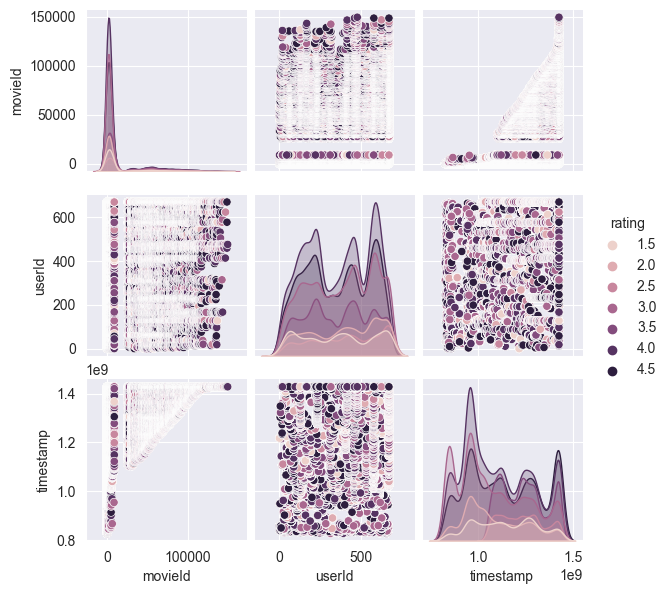

In [17]:
sns.pairplot(data, hue="rating", diag_kind="kde", height=2)

3.Preparing for cosine similarity

In [18]:
users = data.groupby("userId").count()["rating"] > 200
users_index = users[users].index

In [19]:
prominent_users = data[data["userId"].isin(users_index)]
prominent_users

,movieId,title,userId,rating,timestamp
7,1,Toy Story (1995),29,4.0,8.469426e+08
10,1,Toy Story (1995),32,4.0,9.040930e+08
11,1,Toy Story (1995),38,4.5,1.385176e+09
12,1,Toy Story (1995),44,1.5,1.225239e+09
16,1,Toy Story (1995),54,3.0,1.146936e+09
...,...,...,...,...,...
105334,148238,A Very Murray Christmas (2015),475,3.0,1.427694e+09
105335,148626,The Big Short (2015),458,4.0,1.427694e+09
105336,148626,The Big Short (2015),576,4.5,1.427694e+09
105337,148626,The Big Short (2015),668,4.5,1.427694e+09


In [20]:
books = prominent_users.groupby("title").count()["rating"] >= 50
prominent_books = books[books].index

In [21]:
final_ratings = prominent_users[prominent_users["title"].isin(prominent_books)]

In [22]:
final_table = final_ratings.pivot_table(index="title", columns="userId", values="rating")
final_table

userId,22,24,29,32,38,44,54,60,62,63,...,607,615,622,627,628,650,659,665,666,668
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),NaN,NaN,4.0,4.0,2.5,NaN,NaN,NaN,NaN,NaN,...,4.5,4.5,NaN,NaN,4.5,NaN,NaN,NaN,NaN,3.0
"Abyss, The (1989)",NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.5,NaN,NaN,3.5,NaN,NaN,NaN,3.5,4.0,3.0
Ace Ventura: Pet Detective (1994),NaN,NaN,3.0,NaN,NaN,NaN,2.5,NaN,1.5,3.5,...,3.0,NaN,NaN,3.0,NaN,4.5,NaN,3.0,NaN,NaN
Air Force One (1997),NaN,NaN,NaN,4.0,NaN,NaN,3.0,NaN,NaN,4.0,...,3.0,NaN,NaN,2.5,NaN,4.5,4.0,NaN,NaN,2.0
Airplane! (1980),NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.5,3.5,...,3.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Who Framed Roger Rabbit? (1988),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.5,...,4.5,4.0,NaN,4.0,3.5,4.5,NaN,NaN,3.0,2.0
Willy Wonka & the Chocolate Factory (1971),NaN,NaN,NaN,4.0,3.5,NaN,NaN,4.0,1.5,NaN,...,3.0,NaN,NaN,NaN,4.0,4.5,4.5,4.0,NaN,NaN
"Wizard of Oz, The (1939)",2.0,NaN,NaN,4.5,3.5,NaN,NaN,NaN,4.5,NaN,...,3.0,4.0,NaN,NaN,NaN,4.5,NaN,NaN,3.0,4.5


In [23]:
final_table.fillna(0, inplace=True)

In [24]:
final_table

userId,22,24,29,32,38,44,54,60,62,63,...,607,615,622,627,628,650,659,665,666,668
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),0.0,0.0,4.0,4.0,2.5,0.0,0.0,0.0,0.0,0.0,...,4.5,4.5,0.0,0.0,4.5,0.0,0.0,0.0,0.0,3.0
"Abyss, The (1989)",0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.5,0.0,0.0,3.5,0.0,0.0,0.0,3.5,4.0,3.0
Ace Ventura: Pet Detective (1994),0.0,0.0,3.0,0.0,0.0,0.0,2.5,0.0,1.5,3.5,...,3.0,0.0,0.0,3.0,0.0,4.5,0.0,3.0,0.0,0.0
Air Force One (1997),0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,4.0,...,3.0,0.0,0.0,2.5,0.0,4.5,4.0,0.0,0.0,2.0
Airplane! (1980),0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.5,3.5,...,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Who Framed Roger Rabbit? (1988),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.5,...,4.5,4.0,0.0,4.0,3.5,4.5,0.0,0.0,3.0,2.0
Willy Wonka & the Chocolate Factory (1971),0.0,0.0,0.0,4.0,3.5,0.0,0.0,4.0,1.5,0.0,...,3.0,0.0,0.0,0.0,4.0,4.5,4.5,4.0,0.0,0.0
"Wizard of Oz, The (1939)",2.0,0.0,0.0,4.5,3.5,0.0,0.0,0.0,4.5,0.0,...,3.0,4.0,0.0,0.0,0.0,4.5,0.0,0.0,3.0,4.5


In [25]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(final_table)
similarity

array([[1.        , 0.65145586, 0.53443604, ..., 0.59265934, 0.5713115 ,
        0.37730765],
       [0.65145586, 1.        , 0.5848087 , ..., 0.5339706 , 0.60884107,
        0.44828792],
       [0.53443604, 0.5848087 , 1.        , ..., 0.49537894, 0.65113051,
        0.61396162],
       ...,
       [0.59265934, 0.5339706 , 0.49537894, ..., 1.        , 0.4737216 ,
        0.42135   ],
       [0.5713115 , 0.60884107, 0.65113051, ..., 0.4737216 , 1.        ,
        0.73903457],
       [0.37730765, 0.44828792, 0.61396162, ..., 0.42135   , 0.73903457,
        1.        ]])

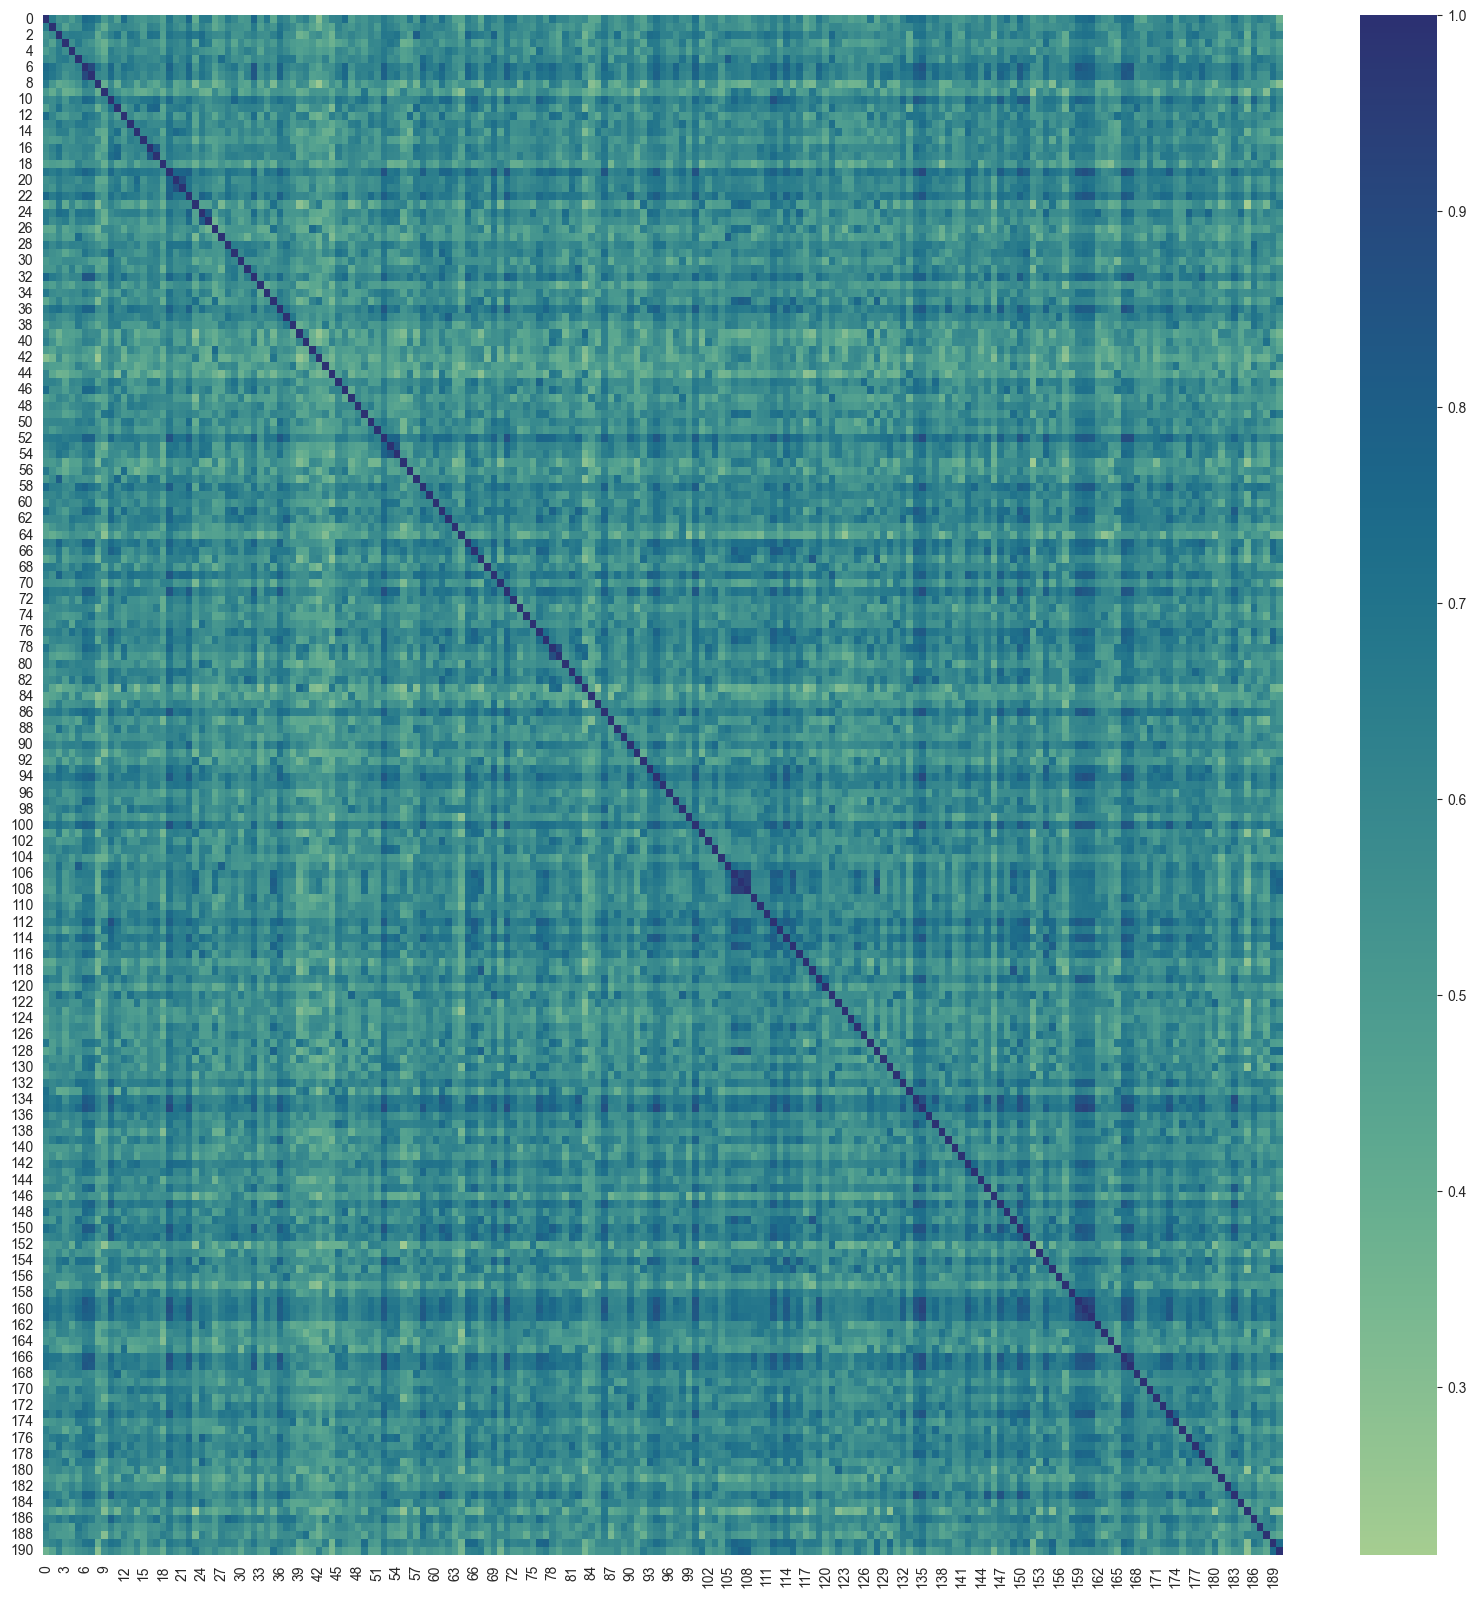

In [26]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(similarity, cmap='crest')
plt.show()

In [27]:
similarity.shape

(191, 191)

In [28]:
similarity[0]

array([1.        , 0.65145586, 0.53443604, 0.56006406, 0.49027788,
       0.58280405, 0.74815259, 0.72068282, 0.66592151, 0.50482772,
       0.59608604, 0.46686089, 0.72752659, 0.58051497, 0.53171447,
       0.51679057, 0.55765755, 0.5366986 , 0.46400346, 0.68561585,
       0.5491792 , 0.56519777, 0.75396539, 0.40456535, 0.6619541 ,
       0.66488344, 0.43043547, 0.50921188, 0.6602885 , 0.58927518,
       0.50246018, 0.51813383, 0.76238475, 0.51256892, 0.67571992,
       0.42399174, 0.63924199, 0.59775427, 0.48047364, 0.57964468,
       0.63418964, 0.48936438, 0.30080466, 0.49660873, 0.6118395 ,
       0.62065479, 0.72960737, 0.47271364, 0.55339947, 0.53205003,
       0.59538721, 0.57930974, 0.65813987, 0.59878951, 0.54127697,
       0.51629415, 0.6727437 , 0.50802139, 0.73940334, 0.60763561,
       0.53887356, 0.70921021, 0.58753936, 0.45505327, 0.44635031,
       0.64637015, 0.57822706, 0.42604666, 0.66283425, 0.61832699,
       0.54934026, 0.69648311, 0.68339506, 0.52972536, 0.57946

4.Recommending movies

In [29]:
def recommend(movie_title):
    index = np.where(final_table.index==movie_title)[0][0]
    similar_items = sorted(list(enumerate(similarity[index])), key=lambda x: x[1], reverse=True)[1:6]
    recommended_items = []
    for i in similar_items:
        recommended_items.append(final_table.index[i[0]])
    return recommended_items


In [31]:
for movies in final_ratings["title"].unique()[:5]:
    print("Recommended movies for \"{movies}\" are:".format(movies=movies))
    for movie in recommend(movies):
        print(" • {movie}".format(movie=movie))
    print("_" * 100 + "\n")

Recommended movies for "Toy Story (1995)" are:
 • Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
 • Jurassic Park (1993)
 • Star Wars: Episode VI - Return of the Jedi (1983)
 • Star Wars: Episode V - The Empire Strikes Back (1980)
 • Star Wars: Episode IV - A New Hope (1977)
____________________________________________________________________________________________________

Recommended movies for "Jumanji (1995)" are:
 • Truman Show, The (1998)
 • Lion King, The (1994)
 • Home Alone (1990)
 • Mars Attacks! (1996)
 • Mask, The (1994)
____________________________________________________________________________________________________

